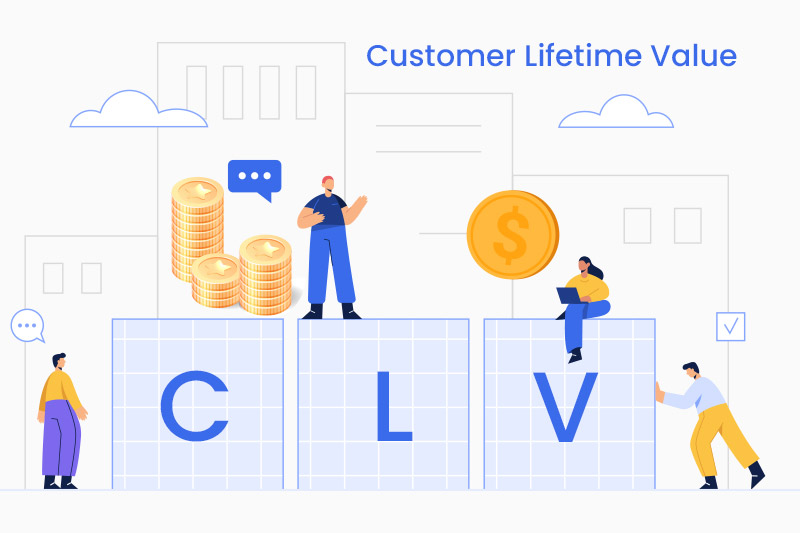
from https://deetaanalytics.com/blog/the-simple-way-to-calculate-customer-lifetime-value-using-analytic/

# Quick look to the data <a id="introduction"></a>
The dataset contains sales data of a Turkey-based company that sells tobacco products. The company has several product categories, including cigarettes, cigars, and pipe tobacco, among others. Cigarettes are the most popular product category, accounting for more than 60% of the company's sales volume and revenue.

# Data Exploration <a id="paragraph1"></a>
***invoiceID:*** Unique Invoice number

***invoice_date:***  Date of purchase

***customerID:*** Unique Customer number

***country:*** Country that purchased the product

***quantity:*** Number of purchased products

***amount:*** Unit price of the sold product

# Customer Lifetime Value (CLV) <a id="paragraph2"></a>
Customer Lifetime Value (CLV) is a customer’s total profit value to your company throughout the time they are your customer. CLV includes all the money they have spent, will spend, and the potential referrals to other prospective clients.

***Benefits;***
* Strategic Decision Making
* Enhanced Customer Experience
* Improved Revenue and Profitability
* Cost Reduction

Overall, understanding and utilizing CLV can lead to improved business performance and customer satisfaction.

# Data Cleaning <a id="paragraph3"></a>

* In here I will prepare the dataset to ready to use for calculation of CLTV & CLTV Prediction. These steps should be done according to what dataset needs. For this dataset, cleaning means get rid of the missing and unlogical values.

In [191]:
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#I will use these libraries that are below to calculate the CLTV prediction.
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [192]:
df_ = pd.read_csv("C:/Users/sg/Desktop/DTSBC-Kendi-notlarım/Projelerim/CLTV/customer_relationship.csv")
df = df_.copy()

In [193]:
def check_df(dataframe, head=10):
    print('\033[1m' + 10*"*" + ' SHAPE ' + 10*"*" + '\033[0m')
    print(f"Rows:{dataframe.shape[0]}")
    print(f"Columns:{dataframe.shape[1]}")
    print('\033[1m' + 10*"*" + ' TYPES ' + 10*"*" + '\033[0m')
    print(dataframe.dtypes)
    print('\033[1m' + 10*"*" + ' NUNIQUE ELEMENTS ' + 10*"*" + '\033[0m')
    print(dataframe.nunique())
    print('\033[1m' + 10*"*" + ' NA ' + 10*"*" + '\033[0m')
    print(dataframe.isnull().sum())
    print('\033[1m' + 10*"*" + ' DESCRIBE ' + 10*"*" + '\033[0m')
    print(dataframe.describe().T)
    print('\033[1m' + 10*"*" + ' DUPLICATED VALUE ' + 10*"*" + '\033[0m')
    print(dataframe.duplicated().sum())
    print('\033[1m' + 10*"*" + ' HEAD ' + 10*"*" + '\033[0m')
    print(dataframe.head(head))
    
check_df(df,10)

********** SHAPE **********
Rows:25953
Columns:6
********** TYPES **********
invoiceID        object
invoice_date     object
customerID      float64
country          object
quantity          int64
amount           object
dtype: object
********** NUNIQUE ELEMENTS **********
invoiceID       25900
invoice_date    23260
customerID       4372
country            38
quantity         1853
amount          17540
dtype: int64
********** NA **********
invoiceID          0
invoice_date       0
customerID      3724
country            0
quantity           0
amount             0
dtype: int64
********** DESCRIBE **********
                count       mean       std         min        25%        50%        75%        max
customerID 22229.0000 15238.2899 1732.9817  12346.0000 13755.0000 15136.0000 16746.0000 18287.0000
quantity   25953.0000   199.4740 1107.0758 -80995.0000     6.0000   100.0000   240.0000 80995.0000
********** DUPLICATED VALUE **********
10
********** HEAD **********
  invoiceID      inv

In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25953 entries, 0 to 25952
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   invoiceID     25953 non-null  object 
 1   invoice_date  25953 non-null  object 
 2   customerID    22229 non-null  float64
 3   country       25953 non-null  object 
 4   quantity      25953 non-null  int64  
 5   amount        25953 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


In [195]:
#I saw that "amount" columns type is object but it is not logical thus I am changing to float.
df['amount'] = df['amount'].str.replace(',', '.')
df['amount'] = df['amount'].astype(float)

In [196]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
customerID,22229.0000,15238.2899,1732.9817,12346.0000,13755.0000,15136.0000,16746.0000,18287.0000
quantity,25953.0000,199.4740,1107.0758,-80995.0000,6.0000,100.0000,240.0000,80995.0000
amount,25953.0000,375.6576,2009.0425,-168469.6000,11.5500,207.0500,408.6600,168469.6000


* **When I look at the results from describe method I saw that min values of quantity and amount is negative but it is not a possible so I will filter the dataset.**
* **I will remove the invoice id columns with a "C" which stands for "Cancel".**
* **I realized that "customerID" has missing values, analyzing without a customer number would not make sense so I will remove these values.**

In [197]:
#I'm removing the invoice id columns with a "C" which stands for "Cancel". I chose the "amount" and "quantity" variables bigger than the zero.
df = df[~df["invoiceID"].str.contains("C", na=False) & (df['amount'] > 0 ) &(df["quantity"] > 0)]

In [198]:
df.dropna(inplace=True)

In [199]:
#In here I looked teh describe result but I saw some extreme values in 75% quantile and max value.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
customerID,18565.0000,15266.2602,1733.9026,12346.0000,13777.0000,15175.0000,16779.0000,18287.0000
quantity,18565.0000,278.4392,971.7600,1.0000,74.0000,155.0000,290.0000,80995.0000
amount,18565.0000,480.1066,1676.6388,0.3800,157.7000,302.8800,471.3000,168469.6000


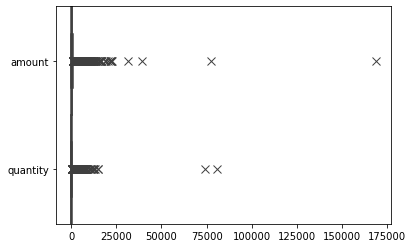

In [200]:
#I can saw these values better with graph.
sns.boxplot(data=df[["amount", "quantity"]], orient="h",flierprops={"marker": "x"}, width=1.0, fliersize=8);

In [201]:
# I write a function to get rid of these outlier values of amount and quantity columns
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

replace_with_thresholds(df, 'quantity')
replace_with_thresholds(df, 'amount')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
customerID,18565.0000,15266.2602,1733.9026,12346.0000,13777.0000,15175.0000,16779.0000,18287.0000
quantity,18565.0000,265.2164,462.1662,1.0000,74.0000,155.0000,290.0000,5673.5000
amount,18565.0000,454.9928,769.3249,0.3800,157.7000,302.8800,471.3000,9598.4680


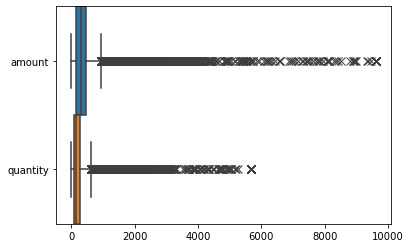

In [202]:
#After removing the outlier values.
sns.boxplot(data=df[["amount", "quantity"]], orient="h",flierprops={"marker": "x"}, width=1.0, fliersize=8);

# Customer Life Time Value Calculation Steps<a id="paragraph4"></a>

1. Average Order Value (average_order_value = total_price / total_transaction)

2. Purchase Frequency (total_transaction / total_number_of_customers)

3. Repeat Rate & Churn Rate (the number of customers who made multiple purchases / all customers)

4. Profit Margin (profit_margin = total_price * 0.33)
* 0.33 is the related with company profit policy. Company should make the decision about this value, for this dataset in history part this value was given as 0.33*

5. Customer Value (customer_value = average_order_value * purchase_frequency)

6. Customer Lifetime Value (CLTV = (customer_value / churn_rate) x profit_margin)

In [203]:
df["totalprice"] = df["quantity"] * df["amount"]

In [204]:
cltv_c = df.groupby('customerID').agg({'invoiceID': lambda x: x.nunique(),
                                        'quantity': lambda x: x.sum(),
                                        'totalprice': lambda x: x.sum()})

cltv_c.columns = ['total_transaction', 'total_unit', 'total_price']

In [205]:
cltv_c.head()

,total_transaction,total_unit,total_price
customerID,,,
12346.0000,1,5673.5000,54456908.1980
12347.0000,7,2458.0000,1839237.3600
12348.0000,4,2341.0000,1422255.6400
12349.0000,1,631.0000,1109014.0500
12350.0000,1,197.0000,65876.8000


In [206]:
#1. Average Order Value (average_order_value = total_price / total_transaction)

cltv_c["average_order_value"] = cltv_c["total_price"] / cltv_c["total_transaction"]

#2.Purchase Frequency (total_transaction / total_number_of_customers)

cltv_c.shape[0] #Dataframe rows represent the number of unique customers.
cltv_c["purchase_frequency"] = cltv_c["total_transaction"] / cltv_c.shape[0]

#3.Repeat Rate & Churn Rate (the number of customers who made multiple purchases / all customers)

repeat_rate = cltv_c[cltv_c["total_transaction"] > 1].shape[0] / cltv_c.shape[0]

churn_rate = 1 - repeat_rate

#4. Profit Margin (profit_margin = total_price * 0.33)
cltv_c['profit_margin'] = cltv_c['total_price'] * 0.33

#5. Customer Value (customer_value = average_order_value * purchase_frequency)
cltv_c['customer_value'] = cltv_c['average_order_value'] * cltv_c["purchase_frequency"]

#6. Customer Lifetime Value (CLTV = (customer_value / churn_rate) x profit_margin)
cltv_c["cltv"] = (cltv_c["customer_value"] / churn_rate) * cltv_c["profit_margin"]

cltv_c.sort_values(by="cltv", ascending=False).head()

,total_transaction,total_unit,total_price,average_order_value,purchase_frequency,profit_margin,customer_value,cltv
customerID,,,,,,,,
14646.0000,73,152084.5000,1058537852.5900,14500518.5286,0.0168,349317491.3547,244015.1804,247666300851125.6250
18102.0000,60,64124.0000,420707241.9800,7011787.3663,0.0138,138833389.8534,96981.8446,39121374775591.5078
12415.0000,21,50647.0000,393877468.5980,18756069.9332,0.0048,129979564.6373,90797.0190,34290704547103.6328
17450.0000,46,62008.0000,390982171.4940,8499612.4238,0.0106,129024116.5930,90129.5923,33788432204041.5938
14156.0000,55,57308.0000,288281262.2340,5241477.4952,0.0127,95132816.5372,66454.8783,18369061239936.6328


In [207]:
#If I create segments I can understand  the customer profile better so and take action better.
cltv_c["segment"] = pd.qcut(cltv_c["cltv"], 4, labels=["D", "C", "B", "A"])

In [208]:
cltv_c.sort_values(by="cltv", ascending=False).head()

,total_transaction,total_unit,total_price,average_order_value,purchase_frequency,profit_margin,customer_value,cltv,segment
customerID,,,,,,,,,
14646.0000,73,152084.5000,1058537852.5900,14500518.5286,0.0168,349317491.3547,244015.1804,247666300851125.6250,A
18102.0000,60,64124.0000,420707241.9800,7011787.3663,0.0138,138833389.8534,96981.8446,39121374775591.5078,A
12415.0000,21,50647.0000,393877468.5980,18756069.9332,0.0048,129979564.6373,90797.0190,34290704547103.6328,A
17450.0000,46,62008.0000,390982171.4940,8499612.4238,0.0106,129024116.5930,90129.5923,33788432204041.5938,A
14156.0000,55,57308.0000,288281262.2340,5241477.4952,0.0127,95132816.5372,66454.8783,18369061239936.6328,A


In [209]:
cltv_c.groupby("segment").agg({"count", "sum","mean"})

total_transaction               total_unit                        total_price                              average_order_value                            purchase_frequency               profit_margin                              customer_value                         cltv                                       
                    count    sum   mean      count          sum      mean       count             sum         mean               count            sum        mean              count    sum   mean         count             sum         mean          count          sum      mean count                  sum              mean
segment                                                                                                                                                                                                                                                                                                                         
D                    1085   1663 1.5327       1085  106741.0000   98.3788        1085   16560378.4900   15263.0216                1085  12743634.6954  11745.2854               1085 0.3834 0.0004          1085    5464924.9017    5036.7971           1085    3817.5146    3.5184  1085        80065268.6932        73792.8744
C                    1084   2471 2.2795       1084  296479.0000  273.5046        1084   79405036.3200   73251.8785                1084  49562403.1676  45721.7741               1084 0.5696 0.0005          1084   26203661.9856   24173.1199           1084   18304.5266   16.8861  1084      1446705515.0448      1334599.1836
B                    1084   4309 3.9751       1084  724910.0000  668.7362        1084  273820372.7000  252601.8198                1084 114474316.5559 105603.6131               1084 0.9933 0.0009          1084   90360722.9910   83358.6005           1084   63121.3399   58.2300  1084     17376487010.4658     16029969.5669
A                    1085  10089 9.2986       1085 3795613.0000 3498.2608        1085 7463088629.3890 6878422.6999                1085 842151499.9857 776176.4977               1085 2.3257 0.0021          1085 2462819247.6984 2269879.4910           1085 1720398.4853 1585.6207  1085 446369094344683.8125 411400086953.6256

***According to these values I can say that A segment's CLTV is much higher. I can think of segment A should be this company's target their most valuable customers. By providing a superior customer experience, businesses can differentiate themselves from their competitors and attract and retain more high-value customers.***


# CLV Prediction with BG-NBD and Gamma-Gamma models<a id="paragraph5"></a>

#### The BG/NBD-GG model can be used to predict customer behavior, calculate customer lifetime value, and identify high-value customers.

#### The Gamma Gamma submodel is often used in conjunction with the BG/NBD model to estimate the monetary value of a customer's purchases, in addition to the frequency of purchases.

#### The BG/NBD-GG model is a powerful tool for estimating customer lifetime value by combining the BG/NBD model's repeat purchase probability and expected purchases with the Gamma Gamma submodel's estimate of the average transaction value.

***Steps of prediction model;***

1. Expected Number of Transaction with BG-NBD Model

2. Expected Average Profit with Gamma-Gamma Model

3. Calculation of CLTV with BG-NBD and Gamma-Gamma Model

**Before setting up our prediction models, I will calculate the variables that I will use in our model. These are;**
* recency: time since customer's last purchase (weekly)
* T :  customer's age (time since first purchase)
* frequency: number of purchases by the customer
* monetary: the total amount of purchases made by the customer.

In [210]:
#In this prediction I need a time value from the dataset. I am changing the variable containing date to the date type. 

df.loc[:, 'invoice_date']= df.loc[:, 'invoice_date'].apply(pd.to_datetime)

df['invoice_date'].max()

Timestamp('2021-12-09 12:50:00')

In [211]:
#I am setting the analysis date as two day after the last date in the dataset.
today_date= dt.datetime(2021,12,11)

In [212]:
cltv_df = df.groupby('customerID').agg({'invoice_date': [lambda invoice_date: (invoice_date.max() - invoice_date.min()).days,
                     lambda invoice_date: (today_date - invoice_date.min()).days],
     'invoiceID': lambda invoiceID: invoiceID.nunique(),
     'totalprice': lambda totalprice: totalprice.sum()})

cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']

cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

cltv_df.describe().T
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
cltv_df["recency"] = cltv_df["recency"] / 7

cltv_df["T"] = cltv_df["T"] / 7

In [213]:
#1. Expected Number of Transaction with BG-NBD Model
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

#Top 10 customers most likely to make a purchase in the 1-month period.
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)

cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

#Top 10 customers most likely to make a purchase in the 3-month period.
bgf.predict(4*3,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)

cltv_df["expected_purc_3_month"] = bgf.predict(4*3,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_month,expected_purc_3_month
customerID,,,,,,
12347.0000,52.1429,52.5714,7,262748.1943,0.5635,1.6784
12348.0000,40.2857,51.2857,4,355563.9100,0.3668,1.0920
12352.0000,37.1429,42.4286,8,18041.4212,0.7271,2.1631
12356.0000,43.1429,46.5714,3,980240.6233,0.3435,1.0222
12358.0000,21.2857,21.5714,2,74799.8000,0.4862,1.4388


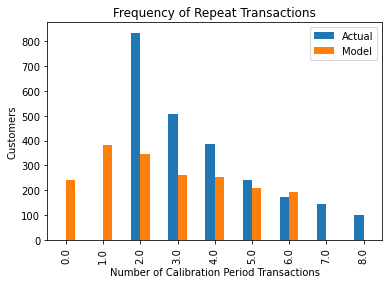

In [214]:
plot_period_transactions(bgf)
plt.show()
#It looks like my model is not too succesfull because there is a gap between actual and model.😅😅

In [215]:
#2. Expected Average Profit with Gamma-Gamma Model

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).head(10)

ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending=False).head(10)

cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])
cltv_df.sort_values("expected_average_profit", ascending=False).head(10)

#I can also observe the potential customer value based on the recency observations here.

#3. Calculation of CLTV with BG-NBD and Gamma-Gamma Model
cltv_predict = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,  # three month
                                   freq="W",  # Frequency information of T (Weekly)
                                   discount_rate=0.01)
cltv_predict.reset_index()

#I am merging the two dataframe (cltv_df, cltv_predict) to get final dataframe.

cltv_final = cltv_df.merge(cltv_predict, on="customerID", how="left")
cltv_final.sort_values(by="clv", ascending=False).head(10)

,recency,T,frequency,monetary,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv
customerID,,,,,,,,
14646.0000,50.4286,50.7143,73,14500518.5286,4.8119,14.3340,14573438.9990,222265514.3587
12415.0000,44.7143,48.2857,21,18756069.9332,1.5139,4.5080,19088081.5001,91552171.4072
18102.0000,52.2857,52.5714,60,7011787.3663,3.8636,11.5112,7054735.0691,86407506.2873
17450.0000,51.2857,52.5714,46,8499612.4238,2.9815,8.8830,8567644.5458,80978807.8553
16000.0000,0.0000,0.4286,3,12595687.6667,1.6639,4.8439,14341893.8702,73750494.2743
14156.0000,51.5714,53.1429,55,5241477.4952,3.5005,10.4298,5276520.0301,58556951.3600
14096.0000,13.8571,14.5714,17,5842932.4688,2.8955,8.5526,5971232.1528,54289816.4713
16684.0000,50.4286,51.2857,28,8270320.8206,1.9068,5.6801,8379635.2521,50643698.1372
17511.0000,52.8571,53.4286,31,7682823.6871,2.0298,6.0476,7774428.2717,50027468.8742


In [217]:
#Now I will make segmentation with final dataframe to obtain the better interpretation.
cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])
cltv_final.sort_values(by="clv", ascending=False).head(30)

,recency,T,frequency,monetary,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv,segment
customerID,,,,,,,,,
14646.0000,50.4286,50.7143,73,14500518.5286,4.8119,14.3340,14573438.9990,222265514.3587,A
12415.0000,44.7143,48.2857,21,18756069.9332,1.5139,4.5080,19088081.5001,91552171.4072,A
18102.0000,52.2857,52.5714,60,7011787.3663,3.8636,11.5112,7054735.0691,86407506.2873,A
17450.0000,51.2857,52.5714,46,8499612.4238,2.9815,8.8830,8567644.5458,80978807.8553,A
16000.0000,0.0000,0.4286,3,12595687.6667,1.6639,4.8439,14341893.8702,73750494.2743,A
14156.0000,51.5714,53.1429,55,5241477.4952,3.5005,10.4298,5276520.0301,58556951.3600,A
14096.0000,13.8571,14.5714,17,5842932.4688,2.8955,8.5526,5971232.1528,54289816.4713,A
16684.0000,50.4286,51.2857,28,8270320.8206,1.9068,5.6801,8379635.2521,50643698.1372,A
17511.0000,52.8571,53.4286,31,7682823.6871,2.0298,6.0476,7774428.2717,50027468.8742,A


In [218]:
cltv_final.groupby("segment").agg({"count", "mean", "sum"})

recency                        T                    frequency              monetary                            expected_purc_1_month                 expected_purc_3_month                  expected_average_profit                              clv                             
          count        sum    mean count        sum    mean     count   sum   mean    count            sum        mean                 count      sum   mean                 count       sum   mean                   count            sum        mean count             sum         mean
segment                                                                                                                                                                                                                                                                                  
D           712 16220.7143 22.7819   712 27811.0000 39.0604       712  2404 3.3764      712  14420576.6913  20253.6189                   712 242.8635 0.3411                   712  720.3217 1.0117                     712  16764595.9926  23545.7809   712   10918663.8317   15335.2020
C           711 21082.7143 29.6522   711 26322.2857 37.0215       711  3381 4.7553      711  31730104.1607  44627.4320                   711 389.2350 0.5474                   711 1154.4371 1.6237                     711  36314397.5259  51075.1020   711   48211295.2492   67807.7289
B           711 21664.0000 30.4698   711 25947.5714 36.4945       711  4208 5.9184      711  71862894.3109 101072.9878                   711 465.3354 0.6545                   711 1380.2652 1.9413                     711  80742344.9647 113561.6666   711  133002441.2578  187063.9118
A           711 21873.4286 30.7643   711 25096.4286 35.2974       711  7046 9.9100      711 561340955.8037 789509.0799                   711 679.4596 0.9556                   711 2016.0884 2.8356                     711 617954234.8199 869133.9449   711 1904014811.4125 2677939.2566